# Recall/MABO as a function of number of proposals included

In [53]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from utils import calculate_iou


def get_ss_proposals(image_name : str):
    # Extract predicted boxes
    with open(os.path.join('Potholes', 'annotated-images', image_name + '_ss.json')) as f:
        pred_boxes = json.load(f)
    
    # Extract bounding box coordinates
    pred_boxes = [pred_box['bbox'] for pred_box in pred_boxes]
    
    return pred_boxes
    

def bounding_box_recall_and_mabo(n_proposals_range, threshold=0.7, proposal_getter = get_ss_proposals):
    #n_proposals_range: list of integers, x-ticks for plot
    #threshold: float in [0,1], IOU threshold for a correct detection
    #proposal_getter: function that takes an image name such as 'img-1' and returns a list of bounding boxes in [xmin, ymin, xmax, ymax] format
    
    # Use only training data
    with open(os.path.join('Potholes', 'splits.json')) as f:
        splits = json.load(f)
    
    xml_names = splits['train']
    
    # Strip .xml
    image_names = [xml_name[:-4] for xml_name in xml_names]
    
    recalls = {k: [] for k in n_proposals_range}
    mabos = {k: [] for k in n_proposals_range}
    
    images_with_this_many_proposals = {k: 0 for k in n_proposals_range}
    
    # Loop through images
    for image_name in image_names:
        # Extract ground truth    
        tree = ET.parse(os.path.join('Potholes', 'annotated-images', image_name + '.xml'))
        root = tree.getroot()
        GT_boxes = [
            [int(box.find("bndbox/xmin").text), 
             int(box.find("bndbox/ymin").text), 
             int(box.find("bndbox/xmax").text), 
             int(box.find("bndbox/ymax").text)]
            for box in root.iter('object')
        ]
        
        pred_boxes = proposal_getter(image_name)
    
        
        
        # Precompute IOUs for all GT and predicted boxes
        iou_matrix = np.array([[calculate_iou(gt_box, pred_box) for pred_box in pred_boxes] for gt_box in GT_boxes])
        
        for n_proposals in n_proposals_range:
            if len(pred_boxes) > n_proposals:
                images_with_this_many_proposals[n_proposals] += 1
            
            
            # Extract only the first included_proposals (may be greater than the number of proposals)
            limited_pred_boxes = pred_boxes[:n_proposals]
            
            # Calculate max IOUs using the precomputed IOU matrix
            max_ious = np.max(iou_matrix[:, :n_proposals], axis=1)
            
            # Threshold
            recalls[n_proposals].append(np.mean(max_ious > threshold))
            
            # Calculate MABO
            mabos[n_proposals].append(np.mean(max_ious))
            
            
    
    # Calculate mean recall and MABO for each n_proposals
    mean_recalls = {k: np.mean(v) for k, v in recalls.items()}
    mean_mabos = {k: np.mean(v) for k, v in mabos.items()}
    
    fraction_of_images = {k: v/len(image_names) for k, v in images_with_this_many_proposals.items()}
    
    
    return mean_recalls, mean_mabos, fraction_of_images

In [54]:
# Example usage
n_proposals_range = np.arange(10, 3000, 30)
recall, mabo, fraction_of_images = bounding_box_recall_and_mabo(n_proposals_range)

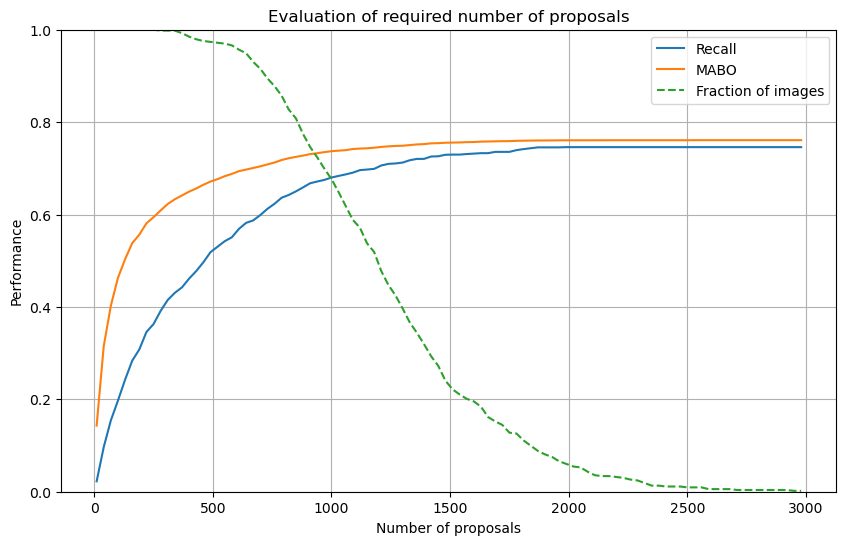

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(n_proposals_range, [recalls[k] for k in n_proposals_range], label='Recall')
plt.plot(n_proposals_range, [mabo[k] for k in n_proposals_range], label='MABO')
plt.plot(n_proposals_range, [fraction_of_images[k] for k in n_proposals_range], '--', label='Fraction of images')

plt.grid(True)
plt.xlabel('Number of proposals')
plt.ylabel('Performance')
plt.title('Evaluation of required number of proposals')
plt.ylim(0, 1)

plt.legend()
plt.show()

# Verify that 'compute_t' and 'alter_box' works as expected

In [3]:
from utils import compute_t, alter_box

In [6]:
test_true_box = [0, 0, 100, 100]
test_prop_box = [5, 10, 110, 120]

t = compute_t(test_true_box, test_prop_box)
print(t)
alter_box(test_prop_box, t)



(-0.047619047619047616, -0.09090909090909091, -0.048790164169432056, -0.0953101798043249)


(0.0, 0.0, 100.0, 100.0)

# Edge boxes

In [7]:
def return_edge_box_proposals(image, max_boxes=100, min_score=0.01):
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Image must be a valid NumPy array.")

    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(max_boxes)
    edge_boxes.setMinScore(min_score)

    edges = cv2.Canny(image, 50, 150)
    edges = edges.astype(np.float32)  # Convert edge map to CV_32F
    orientation_map = np.zeros_like(edges, dtype=np.float32)  # Placeholder orientation map as CV_32F

    bbs = edge_boxes.getBoundingBoxes(edges, orientation_map)[0]

   
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_rgb)

    for bb in bbs:
        x, y, w, h = bb
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()
    return bbs


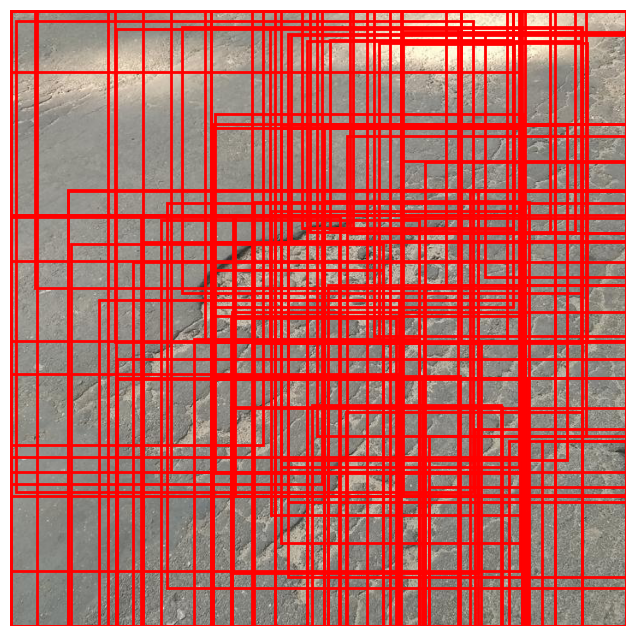

array([[155,   1, 565, 719],
       [ 67, 211, 653, 509],
       [237, 133, 483, 587],
       [309,   1, 411, 719],
       [153, 239, 446, 481],
       [309, 210, 411, 510],
       [  1,   1, 597, 719],
       [143, 294, 577, 426],
       [ 67, 210, 480, 510],
       [259, 353, 461, 367],
       [393, 147, 327, 573],
       [235, 137, 363, 583],
       [457,   1, 263, 719],
       [485, 177, 235, 543],
       [ 71, 273, 365, 447],
       [371, 321, 349, 399],
       [285, 224, 321, 496],
       [  1,   1, 719, 567],
       [237, 357, 365, 363],
       [  1, 293, 599, 427],
       [234,   1, 486, 538],
       [282,   1, 355, 719],
       [176, 245, 301, 475],
       [124, 407, 596, 313],
       [123, 431, 477, 289],
       [  1, 241, 384, 479],
       [483, 321, 237, 399],
       [123,  22, 400, 698],
       [155, 271, 229, 449],
       [259, 465, 461, 255],
       [371, 430, 349, 290],
       [324,  28, 396, 546],
       [227,   1, 493, 386],
       [  1,   1, 719, 385],
       [ 31,  

In [13]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(os.path.join('Potholes', 'annotated-images', 'img-1.jpg'))

return_edge_box_proposals(image)